# Data Exploration

This notebook explores the dataset to understand and get an overview of the dataset:

In [24]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add parent directory to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

from src.utils import load_data
from src.utils import replace_birthdate_with_age
from src.utils import plot_boxplots

- load data
    - load feature data

In [25]:
file_path_features = parent_dir / 'features.parquet'
feature_data = load_data(file_path_features)
#feature_data = feature_data[feature_data['Exposure'] < 1]

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  float64
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  float64
 5   VehAge      678013 non-null  float64
 6   BonusMalus  678013 non-null  float64
 7   VehBrand    678013 non-null  object 
 8   VehGas      644112 non-null  object 
 9   Density     678013 non-null  float64
 10  Region      678013 non-null  object 
 11  BirthD      678013 non-null  object 
dtypes: float64(7), object(5)
memory usage: 62.1+ MB
None


##########################################################################
First 5 Rows:
   IDpol  ClaimNb  Exposure Area  VehPower  VehAge  BonusMalus VehBrand  \
0    1.0      1.0      0.10  'D'       5.0     0.0        50.

- load target data

In [26]:
file_path_target = parent_dir / 'target.parquet'
target_data = load_data(file_path_target)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26639 entries, 0 to 26638
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        26639 non-null  float64
 1   ClaimAmount  26639 non-null  float64
dtypes: float64(2)
memory usage: 416.4 KB
None


##########################################################################
First 5 Rows:
       IDpol  ClaimAmount
0     1552.0       995.20
1  1010996.0      1128.12
2  4024277.0      1851.11
3  4007252.0      1204.00
4  4046424.0      1204.00


##########################################################################
Summary Statistics:
              IDpol   ClaimAmount
count  2.663900e+04  2.663900e+04
mean   2.279864e+06  2.278536e+03
std    1.577202e+06  2.929748e+04
min    1.390000e+02  1.000000e+00
25%    1.087642e+06  6.868100e+02
50%    2.137413e+06  1.172000e+03
75%    3.180162e+06  1.228080e+03
max    6.113971e+06  4.075401e+06


#########

- merge two data sets

In [27]:
# # sum ClaimAmount over identical IDs
target_data = target_data.groupby('IDpol', as_index=False).agg({'ClaimAmount': 'sum'})

feature_data["IDpol"] = feature_data["IDpol"].astype(int)
feature_data.set_index("IDpol", inplace=True)
# merge features and target data
df = pd.merge(feature_data, target_data, on='IDpol', how='left')

df['ClaimAmount'] = df['ClaimAmount'].fillna(0)
# Drop the IDpol column
#df = df.drop(columns=['IDpol'])

-  Data imputation
    - Convert birthdates to ages in year
    - Fill Missing Values with a New Category in VehGas

In [28]:
df['VehGas'] = df['VehGas'].fillna('G3')
df = replace_birthdate_with_age(df, 'BirthD', reference_date='2023-01-01')

- Feature distribution

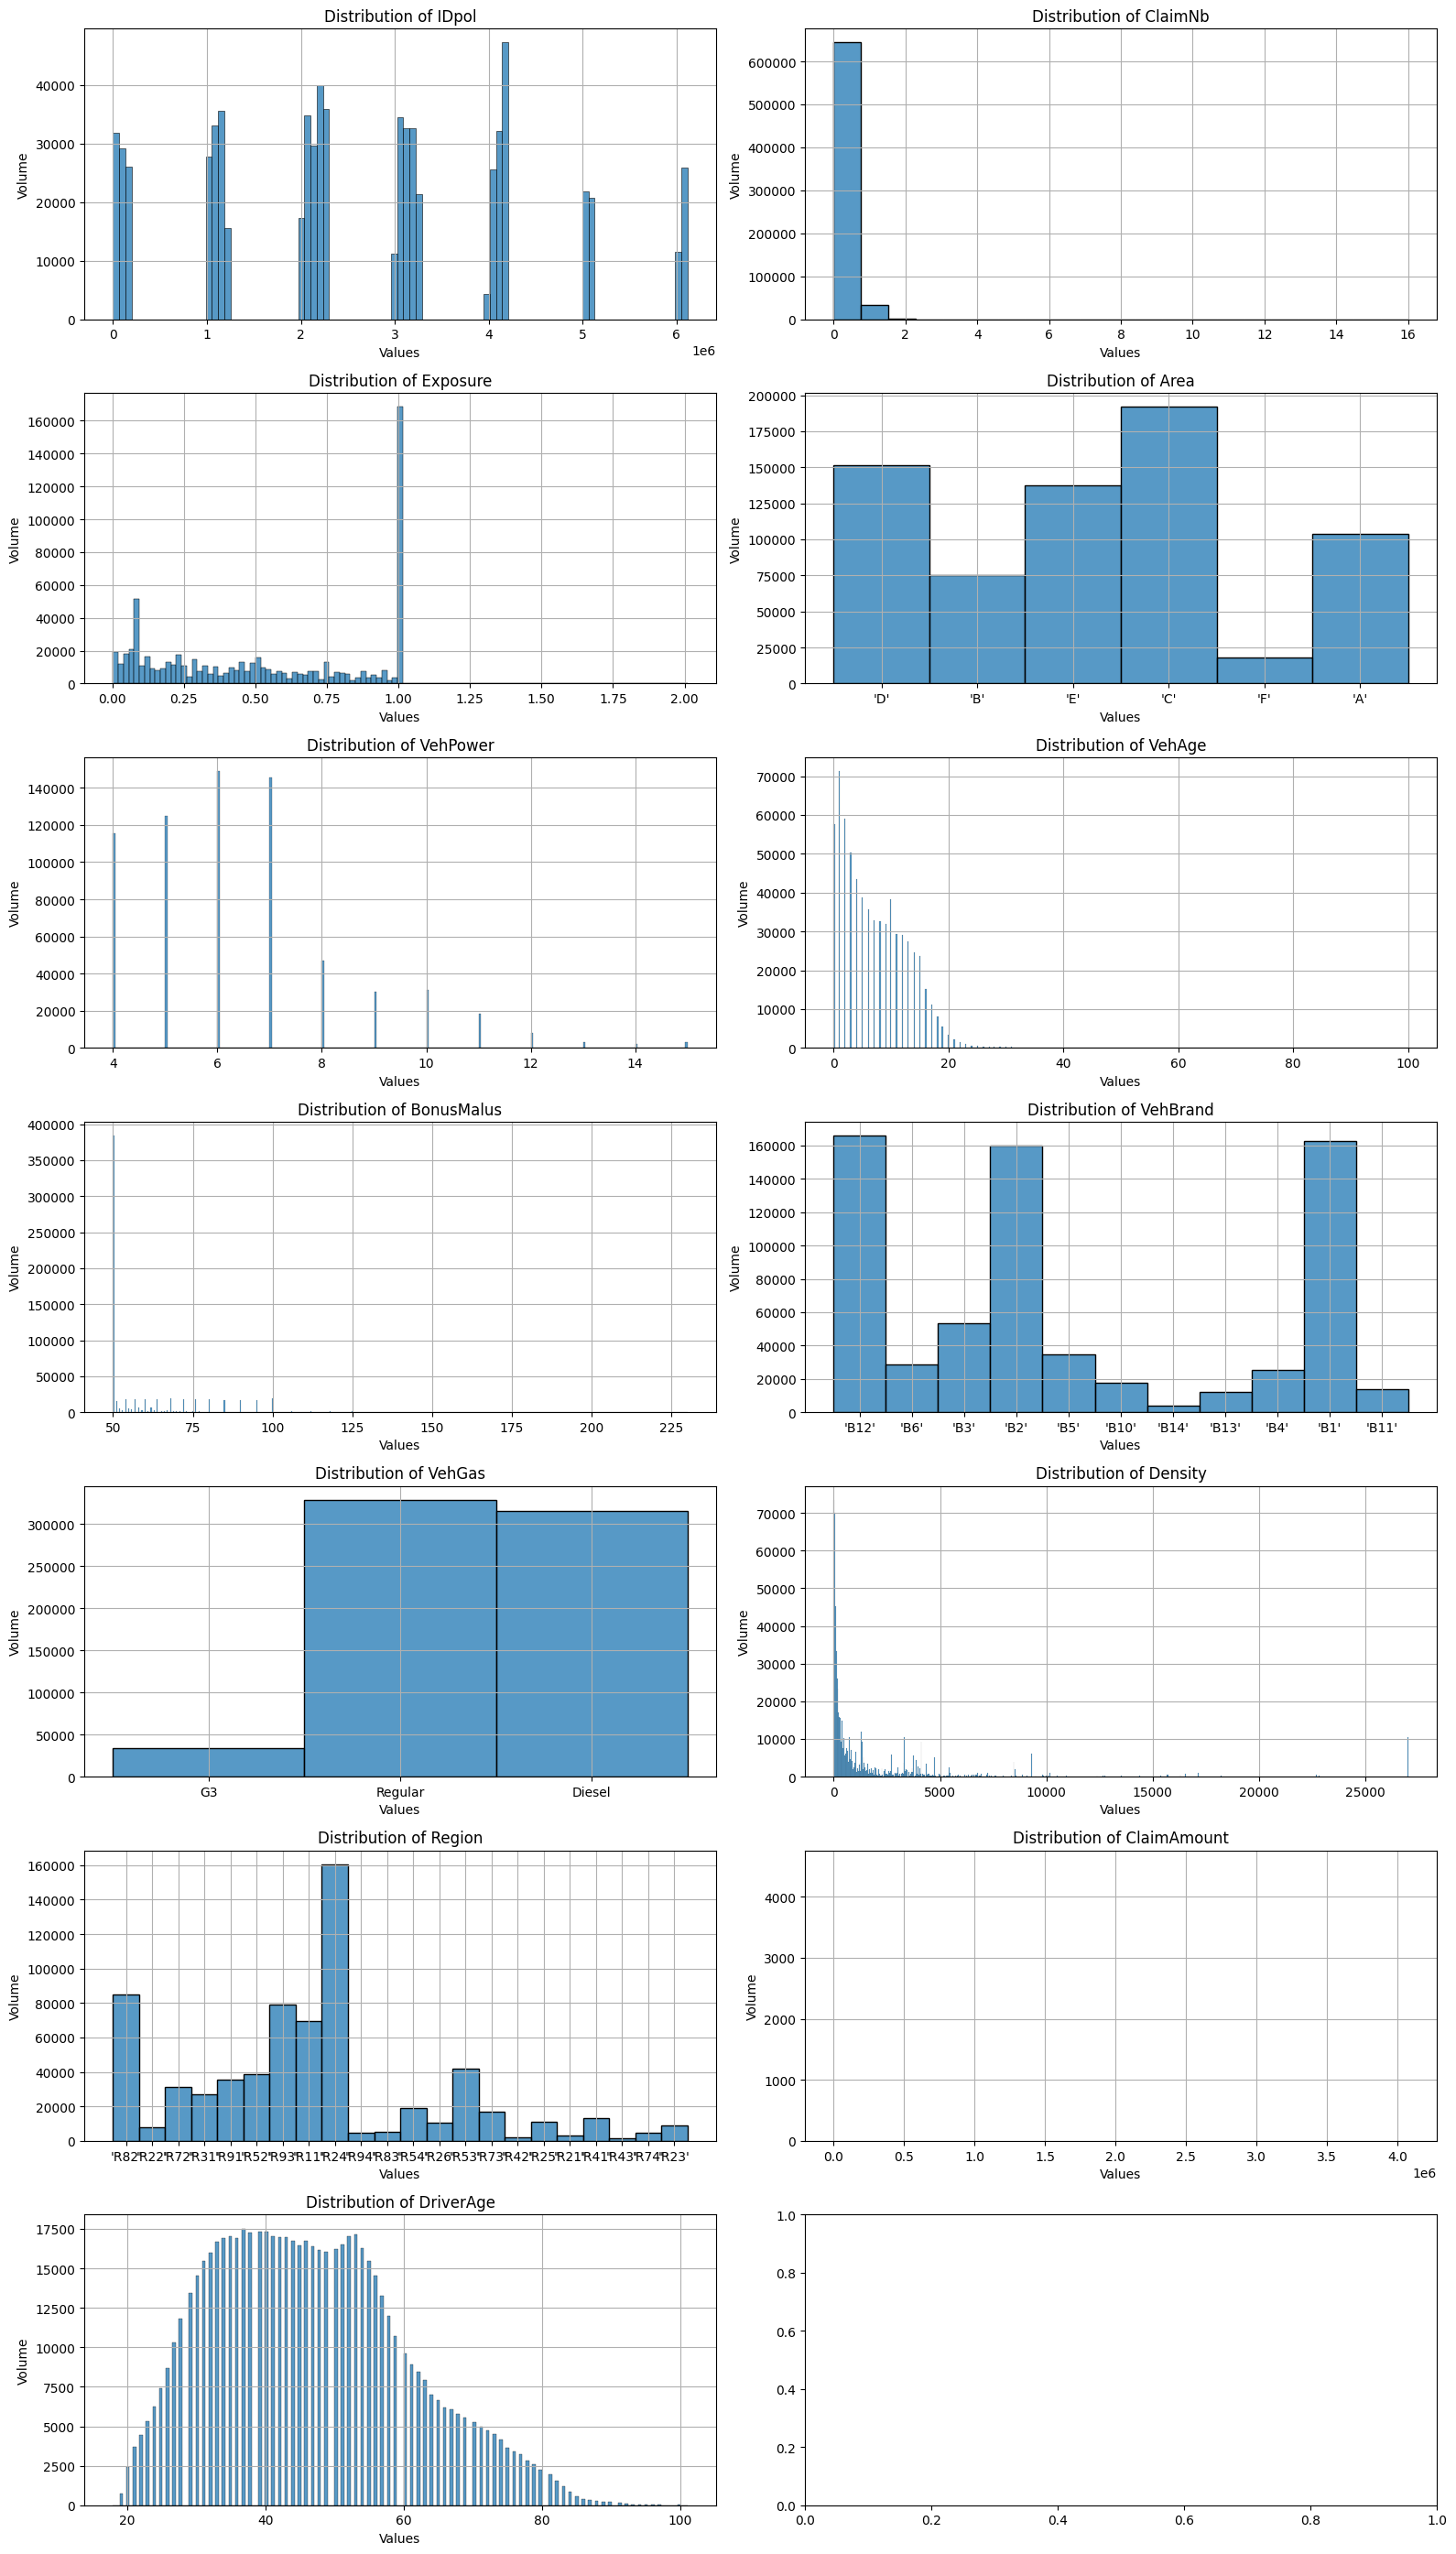

In [16]:
# plot the distribution of each feature
num_columns = len(df.columns)
fig, axes = plt.subplots(nrows=(num_columns + 1) // 2, ncols=2, figsize=(16, 4 * ((num_columns + 1) // 2)))
axes = axes.flatten()

# Plot each column's distribution
for i, column in enumerate(df.columns):
    sns.histplot(df[column], kde=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Volume')
    axes[i].grid(True)
    #axes[i].set_xlim(df[column].min(), df[column].max())

# Adjust layout
plt.tight_layout()
plt.show()

- factorize the categorial features

In [32]:
# List of categorical columns to factorize
categorical_columns = ['Area', 'Region', 'VehGas', 'VehBrand']

# Factorize each categorical column
for column in categorical_columns:
    df[column] = pd.factorize(df[column])[0]

# Display the updated DataFrame
#print(df.head())

- Boxplot to detect outliers

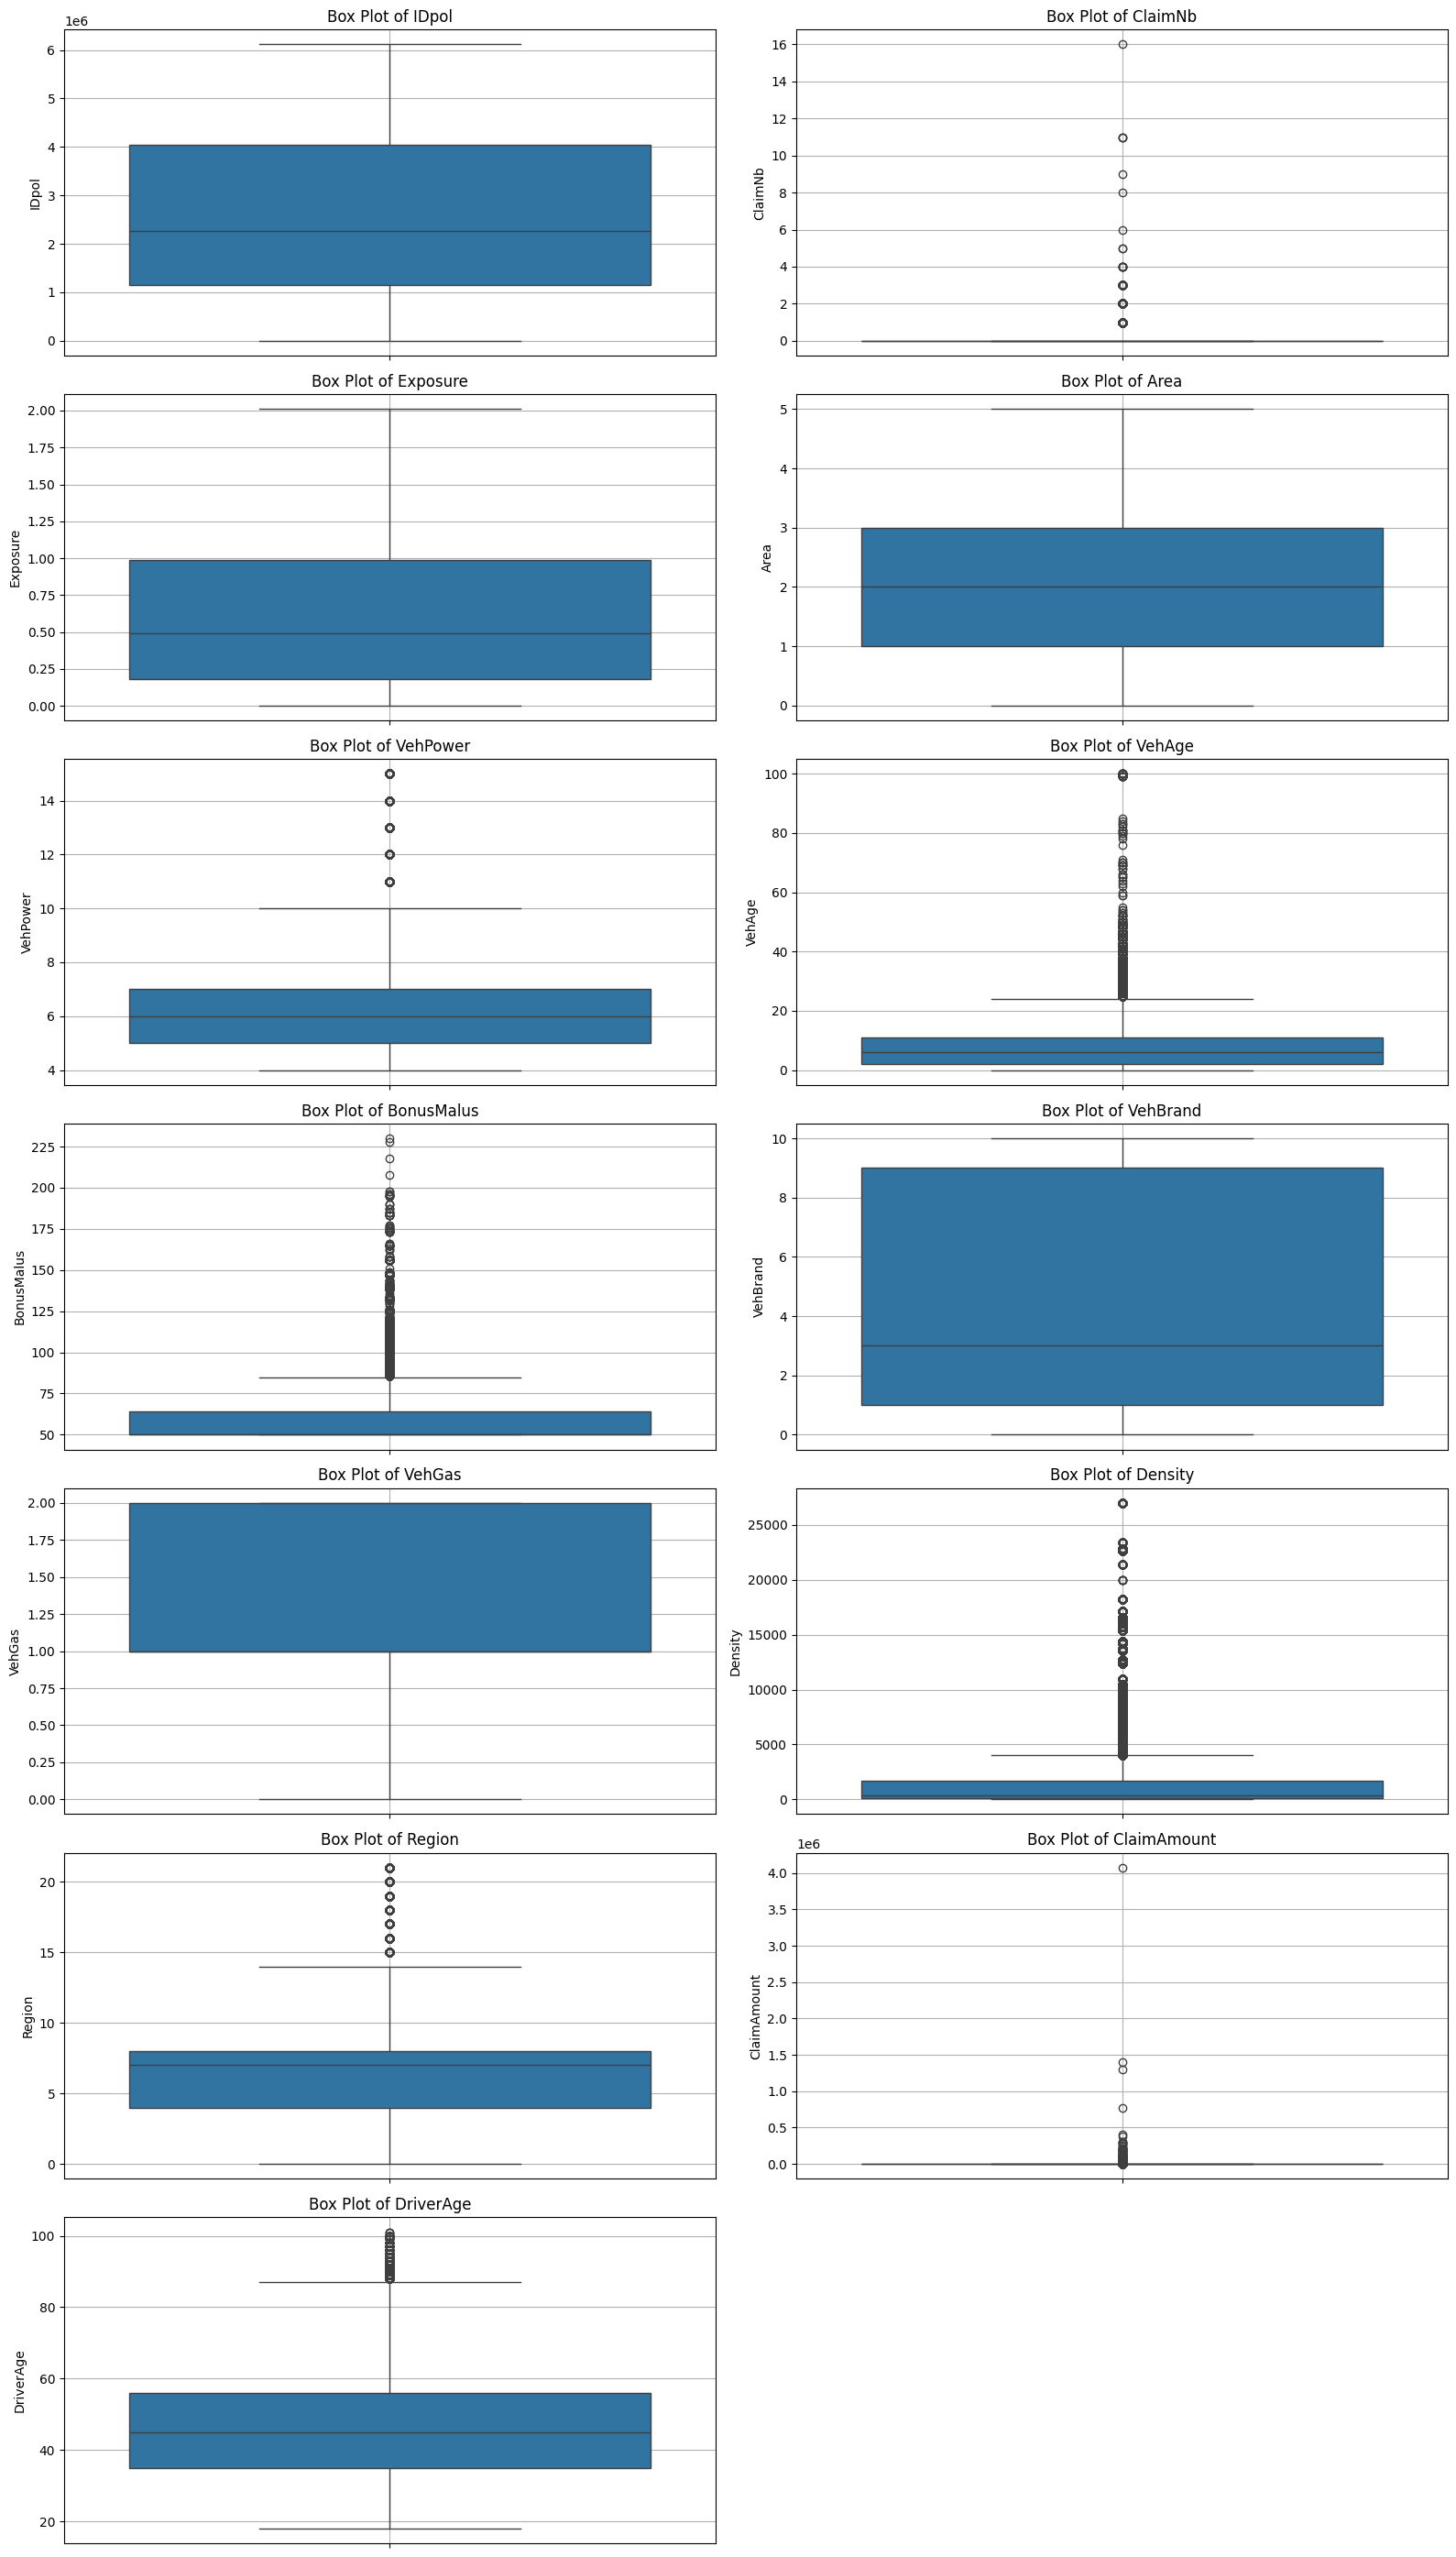

In [18]:
# Select numerical columns
numerical_columns = df.select_dtypes(include=['number']).columns

# Create subplots for box plots
num_columns = len(numerical_columns)
fig, axes = plt.subplots(nrows=(num_columns + 1) // 2, ncols=2, figsize=(16, 4 * ((num_columns + 1) // 2)))
axes = axes.flatten()

# Plot each numerical column as a box plot
for i, column in enumerate(numerical_columns):
    sns.boxplot(data=df, y=column, ax=axes[i])
    axes[i].set_title(f'Box Plot of {column}')
    axes[i].set_ylabel(column)
    axes[i].grid(True)

# Hide unused subplots if the number of columns is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

### feature enginearing

- define the loss amount

In [29]:
df['LossAmount_frequency'] = df['ClaimAmount'] / df['Exposure']
df['Claim_frequency'] = df['ClaimNb'] / df['Exposure']

- observe dependency of Loss_amount_frequency/ Claim_frequency on variables

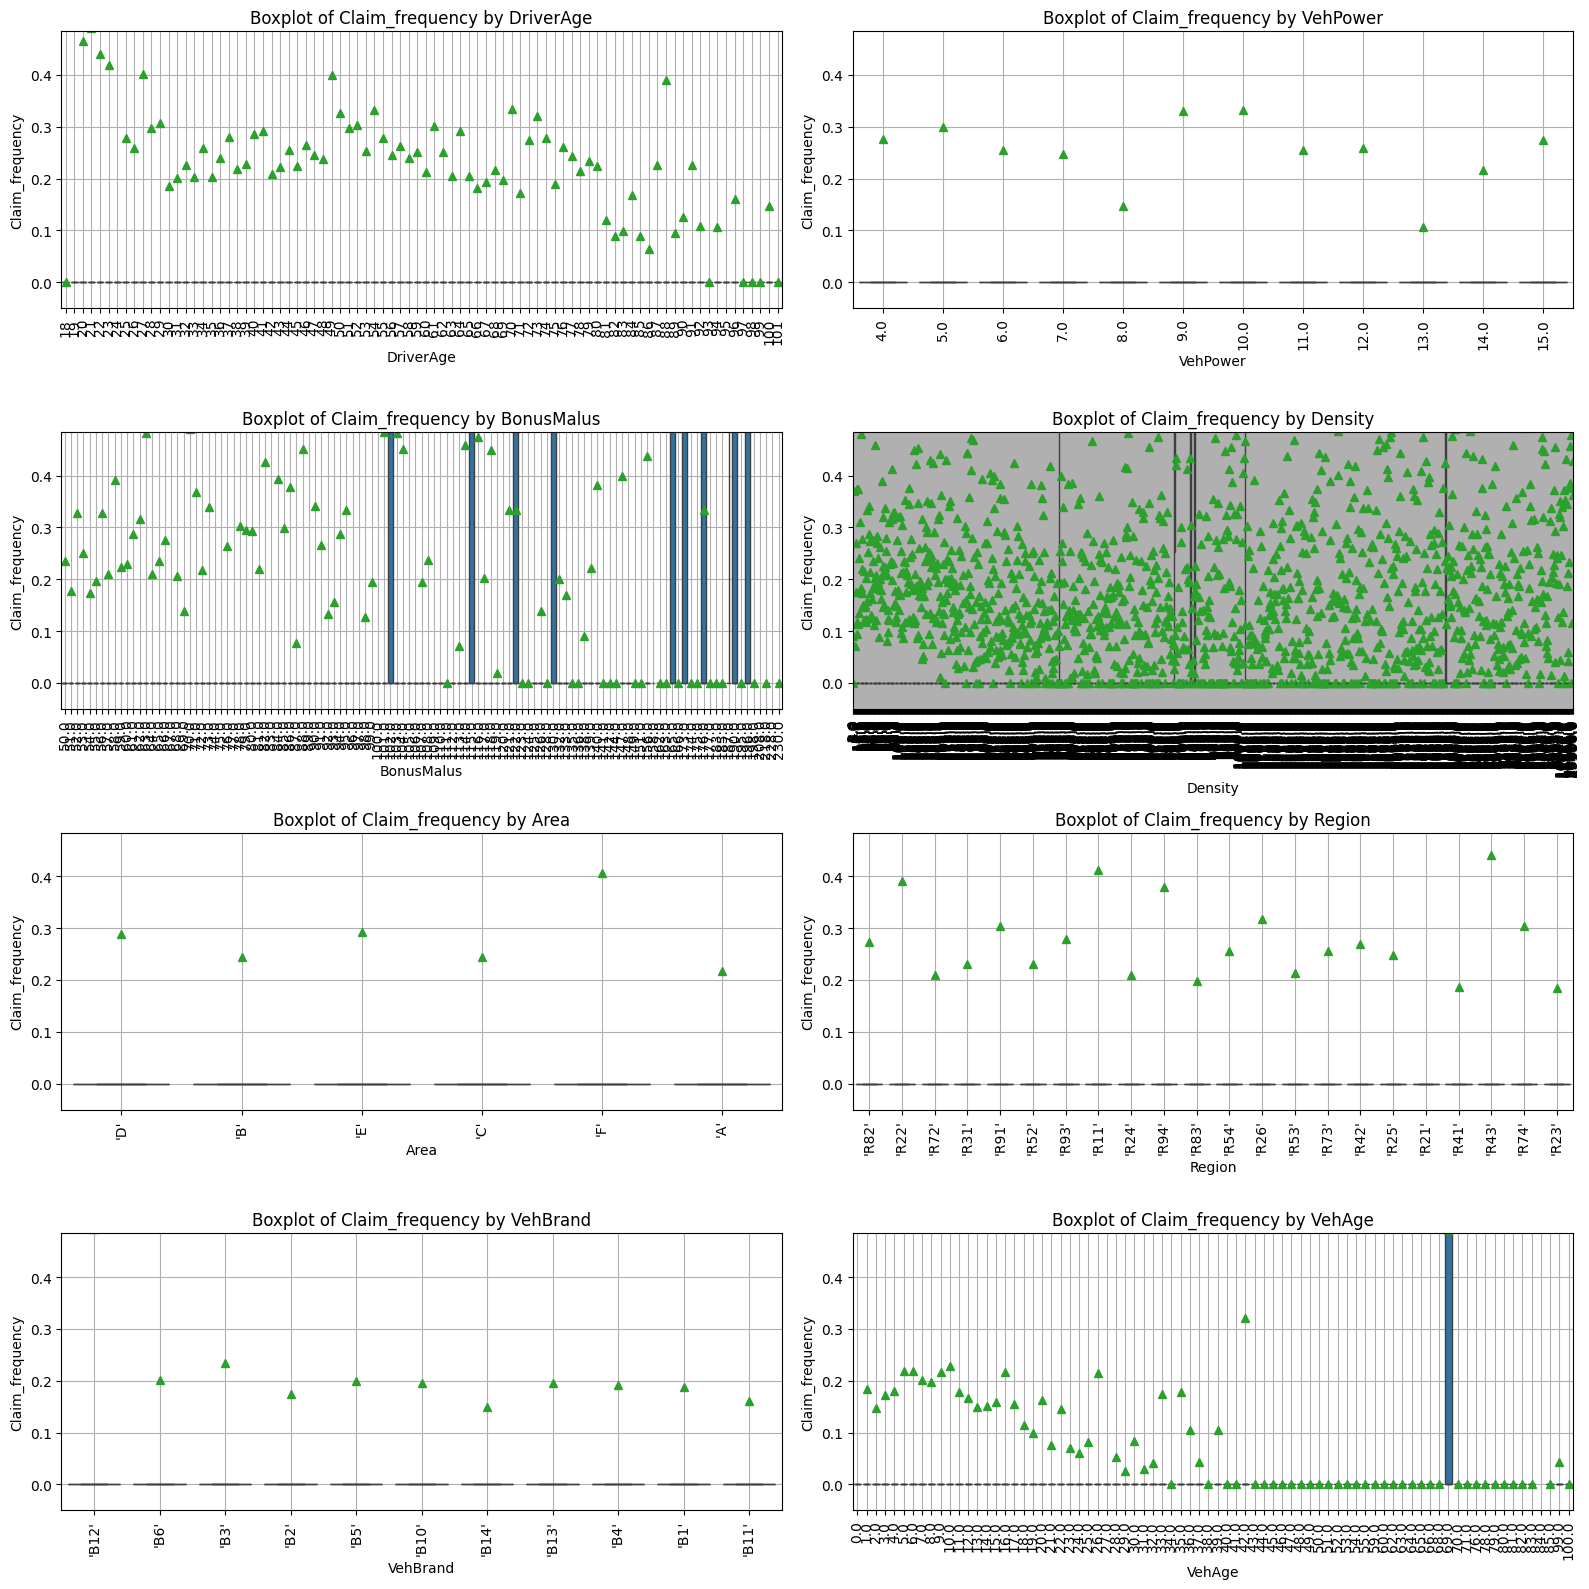

In [7]:
# Example usage:
plot_boxplots(['DriverAge', 'VehPower', 'BonusMalus', 'Density', 'Area', 'Region', 'VehBrand', 'VehAge'],
              'Claim_frequency',
              df)

- pool of data by Driver age shows Claim frequency to age!

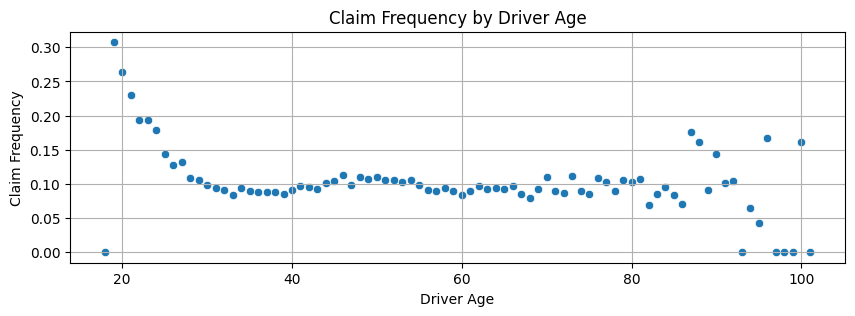

In [ ]:
# sum of ClaimNb and Exposure when grouping by DriverAge
grouped_df = df.groupby('DriverAge').agg({'ClaimNb': 'sum', 'Exposure': 'sum'}).reset_index()
# calculate the claim frequency
grouped_df['Claim_frequency'] = grouped_df['ClaimNb'] / grouped_df['Exposure']
# plot the claim frequency by driver age
plt.figure(figsize=(10, 2))
sns.scatterplot(data=grouped_df, x='DriverAge', y='Claim_frequency')
plt.title('Claim Frequency by Driver Age')
plt.xlabel('Driver Age')
plt.ylabel('Claim Frequency')
plt.grid()
plt.show()

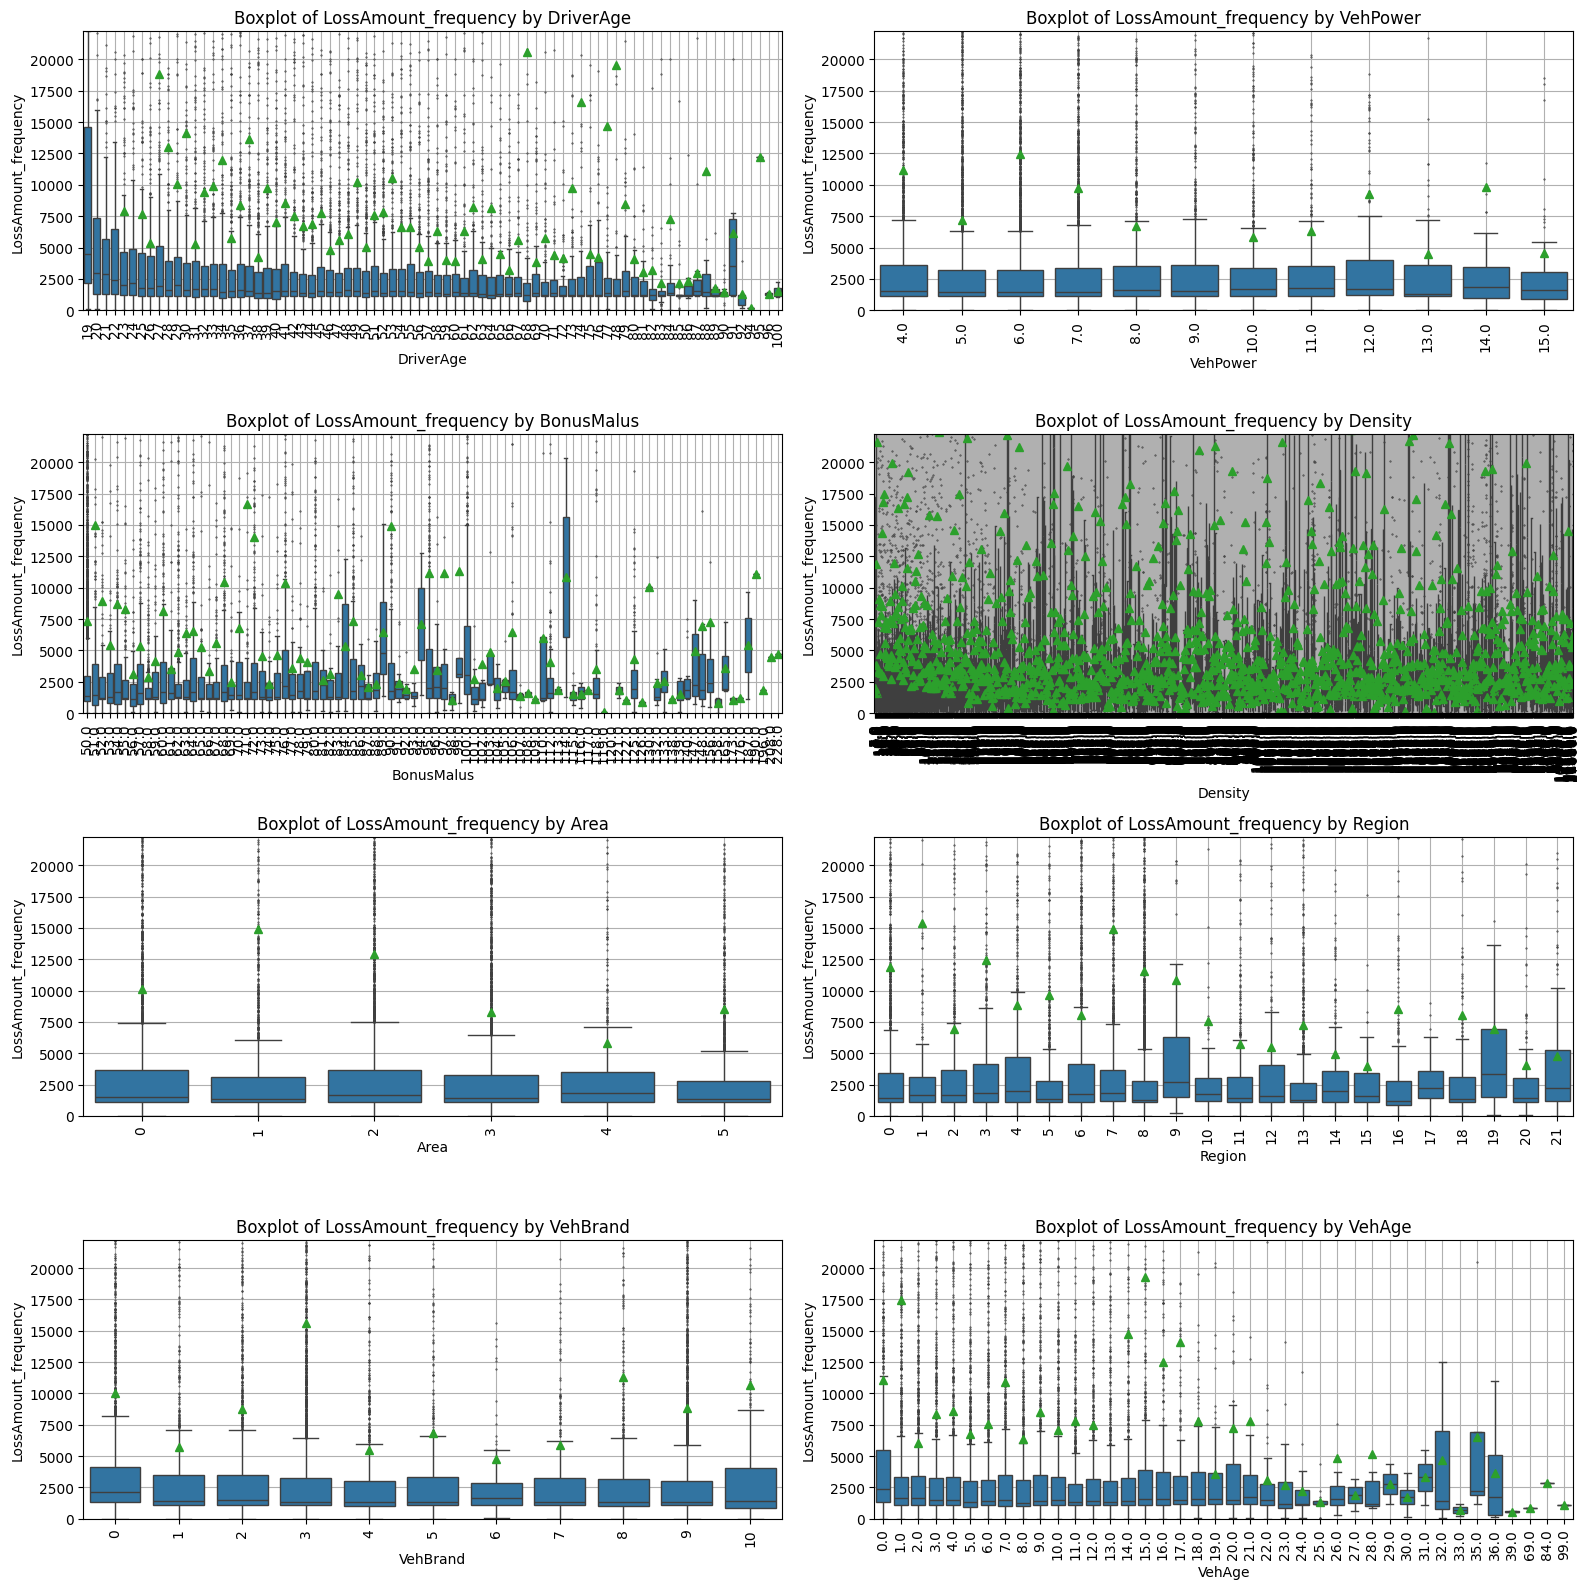

In [35]:
df = df[df['LossAmount_frequency'] > 0]
plot_boxplots(['DriverAge', 'VehPower', 'BonusMalus', 'Density', 'Area', 'Region', 'VehBrand', 'VehAge'], 'LossAmount_frequency', df)

- Feature correlations

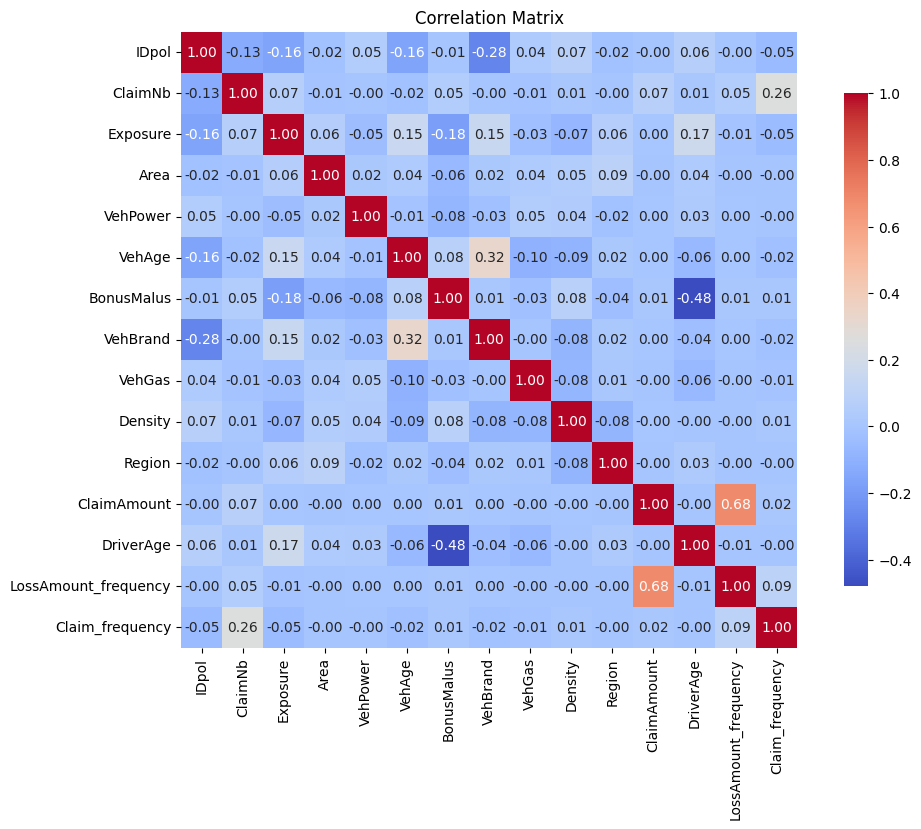

In [33]:
df.corr(method='pearson').style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)
# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

- Scatter plot

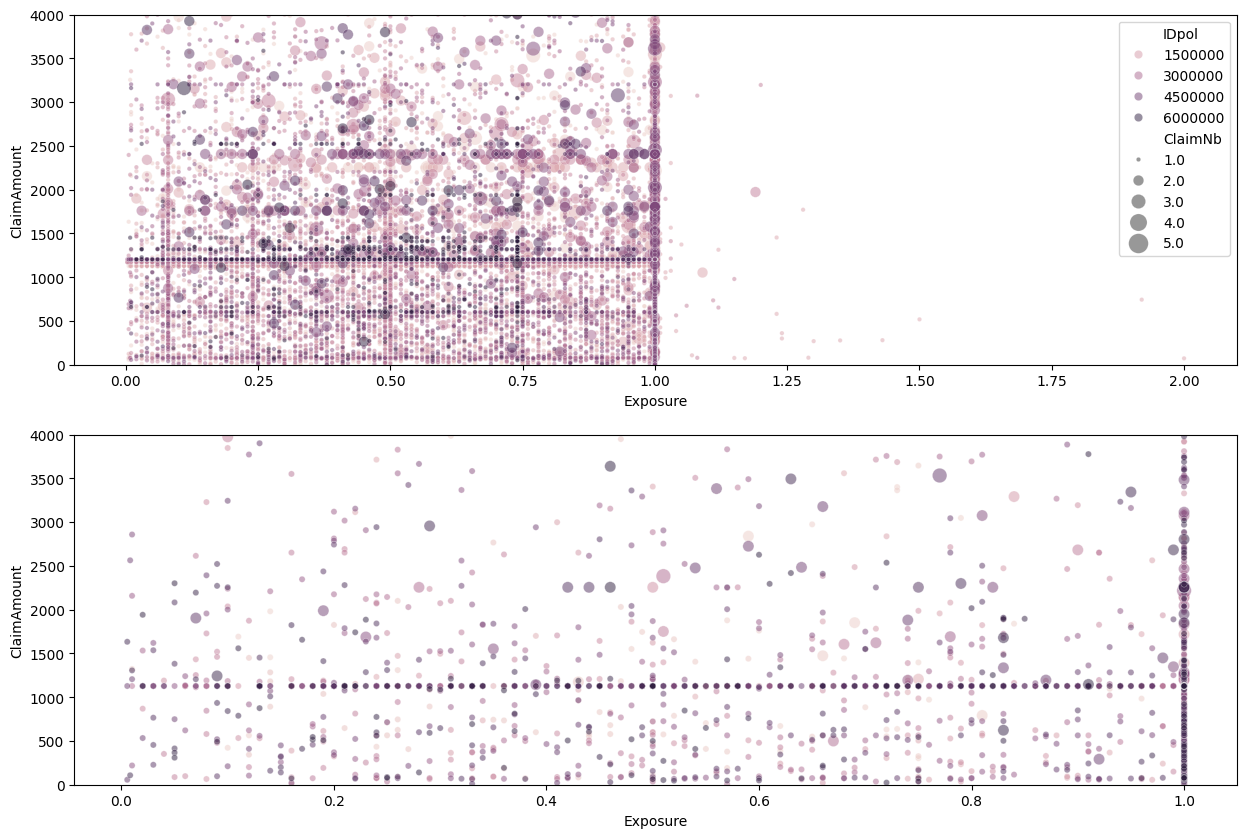

In [49]:
df.loc[:, "ClaimNb"] = df['ClaimNb'].clip(upper=5)
df2 = df[df['IDpol'] < 100000]
# Scatter plot with Claim Amount vs Exposure and IDpol as color and ClaimNb as size
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
scatter_plot = sns.scatterplot(data=df, x='Exposure', y='ClaimAmount', hue='IDpol', size= 'ClaimNb', sizes=(10, 200), alpha=0.5)
scatter_plot.set_ylim(0, 4000)
#scatter_plot.legend_.remove()

plt.subplot(2, 1, 2)

scatter_plot2 = sns.scatterplot(data=df2, x='Exposure', y='ClaimAmount', hue='IDpol', size='ClaimNb', sizes=(20, 200), alpha=0.5)
scatter_plot2.set_ylim(0, 4000)
scatter_plot2.legend_.remove()

plt.show()
